<a href="https://colab.research.google.com/github/Mohd6288/DAMLCP_Project/blob/main/08_diffusion_1_inference_2_img2img.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)

import os
os.chdir('/content/drive/MyDrive/DMLCP-main/DMLCP-main/python') # to change to another directory

Mounted at /content/drive/


In [38]:
from pathlib import Path
from huggingface_hub import notebook_login
if not (Path.home()/'.huggingface'/'token').exists():
    notebook_login()

# Diffusion 2

## Inference 2: Image to Image

Adapted from the [fast.ai repo](https://github.com/fastai/diffusion-nbs).

## Workflow

#### Drive

If you need to load/save to your drive:

```python
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive/')

import os
os.chdir('drive/My Drive/IS53055B-DMLCP/DMLCP/python') # to change to another directory
```

#### Huggingface login

For some models and datasets, and if you want to push your model to HF (same as GitHub, but for models) you need to be logged into your HF account.

For that, you need to create an account [here](https://huggingface.co/) and then to ['/settings/tokens'](https://huggingface.co/settings/tokens) to create an access token.

```python
from pathlib import Path
from huggingface_hub import notebook_login
if not (Path.home()/'.huggingface'/'token').exists():
    notebook_login()
```

#### Install

1. On Colab, just use `pip` to install Huggingface libraries (see below).

2. Locally, the install is the same as the one used for Language models, see [`setup.md`](https://github.com/jchwenger/DMLCP/blob/main/setup.md#pytorch--huggingfacegradio).

In [39]:
import sys

if 'google.colab' in sys.modules:
    !pip install --upgrade transformers diffusers accelerate

In [20]:
import requests
from io import BytesIO
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

import torch

# Get cpu, gpu or mps device for training.
# See: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html#creating-models
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

from diffusers import StableDiffusionImg2ImgPipeline

The convenience function to display a batch of images.

In [21]:
# https://matplotlib.org/stable/gallery/axes_grid1/simple_axesgrid.html
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_images(imgs, rows=1, cols=None, figsize=(12,8), title=None):
    fig = plt.figure(figsize=figsize)           # control figure size
    grid = ImageGrid(
        fig, 111,                                                     # similar to subplot(111) | see: https://stackoverflow.com/a/11404223
        nrows_ncols=(rows, cols if cols is not None else len(imgs)),  # control rows/cols
        axes_pad=0.1,                                                 # pad between axes in inch
    )
    if title is not None:               # https://matplotlib.org/3.2.1/gallery/subplots_axes_and_figures/figure_title.html
        fig.suptitle(title, x=0, y=0.5)

    for ax, im in zip(grid, imgs):      # Iterating over the grid returns the Axes.
        ax.set_xticks([])               # no x/y ticks: https://stackoverflow.com/a/45149018
        ax.set_yticks([])               #               https://stackoverflow.com/a/58535290
        ax.imshow(im)

In [22]:
MODEL_ID = "CompVis/stable-diffusion-v1-4" # same comment as in the first notebook

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    MODEL_ID,
    revision="fp16",
    torch_dtype=torch.float16,
    safety_checker = None # remove NSFW filter
).to("cuda")

# Note: removing the filter is no licence to do harm, it is to give *you* the responsibility
# of your use. (Also, the HF safety_checker is very, very conservative, and rejects
# a lot of abstract images.)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:221: FutureWarning: You are loading the variant fp16 from CompVis/stable-diffusion-v1-4 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis-

In [23]:
SAVE_MEMORY = False

if SAVE_MEMORY:                     # Saves memory at the cost of speed:
    pipe.enable_attention_slicing() #  https://huggingface.co/docs/diffusers/main/en/api/diffusion_pipeline#diffusers.DiffusionPipeline.enable_attention_slicing

if device=="mps":                           # First-time "warmup" pass for M1/M2 macs
    _ = pipe(prompt, num_inference_steps=1) # https://huggingface.co/docs/diffusers/v0.4.1/en/optimization/mps

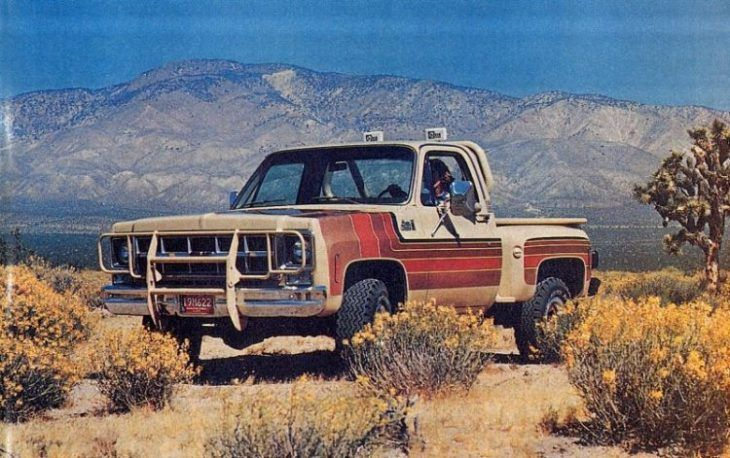

In [24]:
# url = 'https://cdn-uploads.huggingface.co/production/uploads/1664665907257-noauth.png'
url = 'https://i.pinimg.com/736x/c3/09/4c/c3094c5fbb257f0e794a838247f7ef5f.jpg'
response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image

In [25]:
torch.manual_seed(1000)
prompt = "Arbic human robot on the desert driving GMC old truck, photorealistic 4K"
n_img = 3
result = pipe(
    prompt=prompt,
    num_images_per_prompt=n_img,
    image=[init_image]*n_img, # pass the same number of init images
    strength=0.8,
    num_inference_steps=50
)

  0%|          | 0/40 [00:00<?, ?it/s]

In [26]:
result

StableDiffusionPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=728x456 at 0x7C40C44370A0>, <PIL.Image.Image image mode=RGB size=728x456 at 0x7C40C4434160>, <PIL.Image.Image image mode=RGB size=728x456 at 0x7C40C4437C10>], nsfw_content_detected=None)

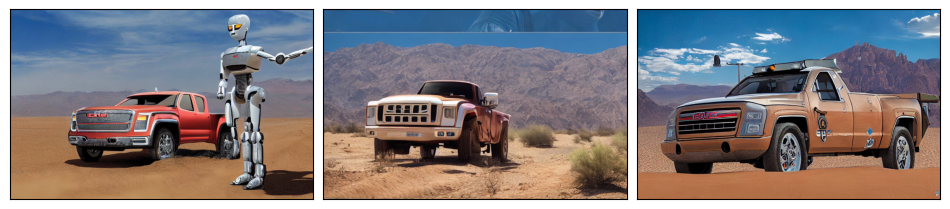

In [27]:
plot_images(result.images, rows=1, cols=3)

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_img2img.py:768: FutureWarning: You have passed 3 text prompts (`prompt`), but only 1 initial images (`image`). Initial images are now duplicating to match the number of text prompts. Note that this behavior is deprecated and will be removed in a version 1.0.0. Please make sure to update your script to pass as many initial images as text prompts to suppress this warning.
  deprecate("len(prompt) != len(image)", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/54 [00:00<?, ?it/s]

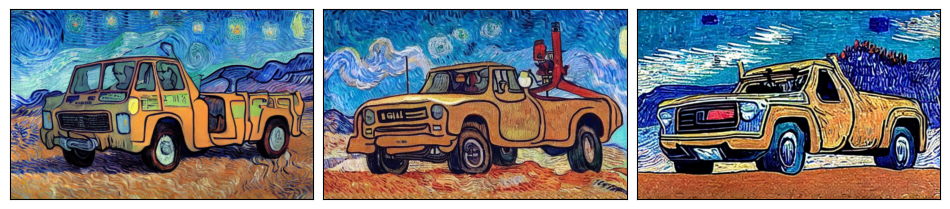

In [28]:
init_image = result.images[2]

torch.manual_seed(1000)
prompt = "The Arbic human robot on the desert driving GMC old truck, painting by Vincent Van Gogh"

images = pipe(
    prompt=prompt,
    num_images_per_prompt=3,
    image=init_image,
    strength=0.78,
    num_inference_steps=70
).images

plot_images(images, rows=1, cols=3)

---

## Extra: upscaling!

Diffusion models have been trained to upscale images! The one below multiplies the image size by 4!

Original notebook [here](https://github.com/huggingface/notebooks/blob/main/diffusers/latent_diffusion_upscaler.ipynb).

The model was originally released in [Latent Diffusion repo](https://github.com/CompVis/latent-diffusion). It's a simple, 4x super-resolution model diffusion model. This model is not conditioned on text.

In [29]:
from diffusers import LDMSuperResolutionPipeline

In [30]:
MODEL_ID = "CompVis/ldm-super-resolution-4x-openimages"
pipe = LDMSuperResolutionPipeline.from_pretrained(
    MODEL_ID,
    # revision="fp16",           # better for memory, unsure if that has
    # torch_dtype=torch.float16, # an impact on image quality...
).to(device)

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/vqvae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/vqvae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


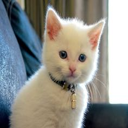

In [31]:
# let's download an  image
url = "https://i.pinimg.com/236x/af/84/56/af8456faa55d76bd9afa18cd2fd72d58.jpg"
# url = 'https://amdirac.wordpress.com/wp-content/uploads/2020/10/camel.jpg'
# url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/43/07._Camel_Profile%2C_near_Silverton%2C_NSW%2C_07.07.2007.jpg/640px-07._Camel_Profile%2C_near_Silverton%2C_NSW%2C_07.07.2007.jpg'
response = requests.get(url)
low_res_img = Image.open(BytesIO(response.content)).convert("RGB")

n = 128
low_res_img = low_res_img.resize((n,n))
low_res_img

  0%|          | 0/100 [00:00<?, ?it/s]

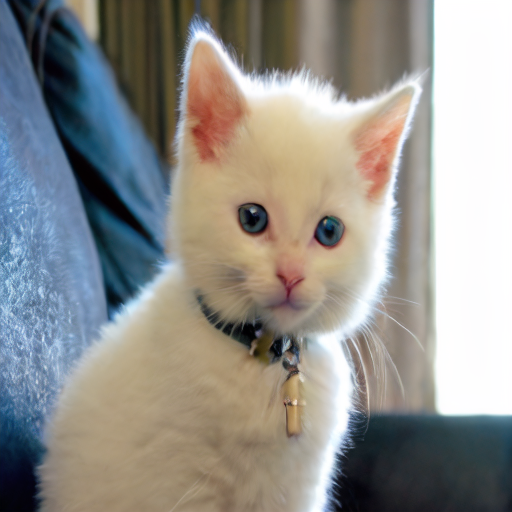

In [32]:
# run pipeline in inference (sample random noise and denoise)
upscaled_image = pipe(
    low_res_img,
    num_inference_steps=100,
    eta=1
).images[0]

upscaled_image

## Experiments

- Can you build a pipeline that repeats the process of generating an image and then selecting one as a basis for the next?
- This is of course also valid for super-resolution, where it might be possible to get interesting results by applying hyperresolution serveral times in a row (perhaps upscale, then select a portion of the result image, upscale again...)..
- How do you display your results? Note that, as with GANs, if you create a series of images, you can then merge them into a video..
- These are fully compatible with Gradio (you can see the code for many apps using these models on [Huggingface Spaces](https://huggingface.co/spaces?sort=modified&search=diffusion), it could be cool to build your own, or modify an existing one!

In [33]:
!pip install gradio
!pip install pillow

In [50]:
from PIL import ImageEnhance, ImageFilter

def mock_refine_image(image, iteration):
    """
    Simulate an image refinement process with visual transformations.
    Args:
        image: Input PIL image.
        iteration: Current iteration number.
    Returns:
        Refined PIL Image.
    """
    # Increase contrast progressively
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(1 + 0.1 * iteration)

    # Apply Gaussian blur progressively
    image = image.filter(ImageFilter.GaussianBlur(radius=iteration * 0.5))

    # Add iteration text
    draw = ImageDraw.Draw(image)
    draw.text((10, 10), f"Iteration {iteration}", fill=(255, 0, 0))
    return image


In [51]:
def crop_image(image, region=(50, 50, 200, 200)):
    """
    Crop the image to a specific region.
    """
    return image.crop(region)


In [52]:
def create_gif(images, output_path="refinement.gif", duration=500):
    """
    Create an animated GIF from a list of PIL images.
    """
    images[0].save(
        output_path, save_all=True, append_images=images[1:], duration=duration, loop=0
    )
    return output_path


In [53]:
import gradio as gr

def gradio_refine(image, iterations):
    """
    Gradio interface for image refinement.
    Args:
        image: Input PIL image.
        iterations: Number of refinement iterations.
    Returns:
        Tuple of gallery and GIF file path.
    """
    refined_images = refine_pipeline(image, iterations)
    gif_path = create_gif(refined_images, "refinement.gif")
    return refined_images, gif_path

interface = gr.Interface(
    fn=gradio_refine,
    inputs=[
        gr.Image(type="filepath", label="Upload Initial Image"),
        gr.Slider(minimum=1, maximum=10, value=3, label="Number of Refinement Iterations")
    ],
    outputs=[
        gr.Gallery(label="Refinement Steps"),
        gr.File(label="Download Refinement GIF")
    ]
)

interface.launch(debug=True)


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/PIL/Image.py", line 3475, in open
    fp.seek(0)
AttributeError: 'NoneType' object has no attribute 'seek'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 624, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 323, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 2015, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1562, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asy

In [54]:
# Set up the model
MODEL_ID = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    MODEL_ID,
    revision="fp16",
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")

# Pre-load an initial image
init_image_url = "https://i.pinimg.com/736x/c3/09/4c/c3094c5fbb257f0e794a838247f7ef5f.jpg"
init_image = Image.open(requests.get(init_image_url, stream=True).raw).convert("RGB")

# Function to run the pipeline
def generate_images(prompt, strength, num_images, num_steps):
    """
    Generate images using the Stable Diffusion pipeline.
    Args:
        prompt (str): Text prompt for the image generation.
        strength (float): Strength parameter (0 to 1).
        num_images (int): Number of images to generate.
        num_steps (int): Number of inference steps.
    Returns:
        List of generated PIL images.
    """
    torch.manual_seed(1000)  # Set manual seed for reproducibility
    results = pipe(
        prompt=prompt,
        num_images_per_prompt=num_images,
        image=[init_image] * num_images,
        strength=strength,
        num_inference_steps=num_steps
    )
    return results.images

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:221: FutureWarning: You are loading the variant fp16 from CompVis/stable-diffusion-v1-4 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis-

In [56]:


# Define the Gradio interface
interface = gr.Interface(
    fn=generate_images,
    inputs=[
        gr.Textbox(lines=2, placeholder="Enter your prompt here", label="Prompt"),
        gr.Slider(0.0, 1.0, value=0.8, step=0.01, label="Strength"),
        gr.Slider(1, 5, value=3, step=1, label="Number of Images"),
        gr.Slider(10, 100, value=50, step=1, label="Inference Steps")
    ],
    outputs=gr.Gallery(label="Generated Images")  # Gallery works with file paths
)

interface.launch(debug=True)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [60]:
# Function to run the pipeline and save GIF
def generate_images_with_gif(prompt, strength, num_images, num_steps):
    """
    Generate images using the Stable Diffusion pipeline and create a GIF.
    Args:
        prompt (str): Text prompt for the image generation.
        strength (float): Strength parameter (0 to 1).
        num_images (int): Number of images to generate.
        num_steps (int): Number of inference steps.
    Returns:
        List of file paths to generated images and GIF file path.
    """
    torch.manual_seed(1000)  # Set manual seed for reproducibility
    results = pipe(
        prompt=prompt,
        num_images_per_prompt=num_images,
        image=[init_image] * num_images,
        strength=strength,
        num_inference_steps=num_steps
    )

    # Save images to disk
    image_paths = []
    images = results.images
    for i, img in enumerate(images):
        file_path = f"generated_image_{i}.png"
        img.save(file_path)
        image_paths.append(file_path)

    # Create a GIF
    gif_path = "generated_images.gif"
    images[0].save(
        gif_path, save_all=True, append_images=images[1:], duration=500, loop=0
    )

    return image_paths, gif_path

# Define the Gradio interface
def gradio_pipeline_with_gif(prompt, strength, num_images, num_steps):
    image_paths, gif_path = generate_images_with_gif(prompt, strength, num_images, num_steps)
    return image_paths, gif_path

interface = gr.Interface(
    fn=gradio_pipeline_with_gif,
    inputs=[
        gr.Textbox(lines=2, placeholder="Enter your prompt here", label="Prompt"),
        gr.Slider(0.0, 1.0, value=0.8, step=0.01, label="Strength"),
        gr.Slider(1, 5, value=3, step=1, label="Number of Images"),
        gr.Slider(10, 100, value=50, step=1, label="Inference Steps")
    ],
    outputs=[
        gr.Gallery(label="Generated Images"),
        gr.File(label="Download Generated GIF")
    ]
)

interface.launch(debug=True)

  0%|          | 0/40 [00:00<?, ?it/s]